<h1 align="center">Introduction to Machine Learning - 25737-2</h1>
<h4 align="center">Dr. R. Amiri</h4>
<h4 align="center">Sharif University of Technology, Spring 2024</h4>


**<font color='red'>Plagiarism is strongly prohibited!</font>**


**Student Name**: Mohammad Mohammad Beigi

**Student ID**: 99102189





## Importing Libraries

First we import libraries that we need for this assignment.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# import any other libraries needed below

## Reading Data and Preprocessing

In this section, we want to read data from a CSV file and then preprocess it to make it ready for the rest of the problem.

First, we read the data in the cell below and extract an $m \times n$ matrix, $X$, and an $m \times 1$ vector, $Y$, from it, which represent our knowledge about the features of the data (`X1`, `X2`, `X3`) and the class (`Y`), respectively. Note that by $m$, we mean the number of data points and by $n$, we mean the number of features.

In [ ]:
import pandas as pd

# Load the dataset
data = pd.read_csv('/content/data3_logistic.csv')

# Assuming the last column is the target and the others are features
X = data.iloc[:, :-1].values  # Extract all rows and all columns except the last as a numpy array
Y = data.iloc[:, -1].values   # Extract all rows for the last column as a numpy array

print(X.shape)
print(Y.shape)

(10000, 3)
(10000,)


Next, we should normalize our data. For normalizing a vector $\mathbf{x}$, a very common method is to use this formula:

$$
\mathbf{x}_{norm} = \dfrac{\mathbf{x} - \overline{\mathbf{x}}}{\sigma_\mathbf{x}}
$$

Here, $\overline{x}$ and $\sigma_\mathbf{x}$ denote the mean and standard deviation of vector $\mathbf{x}$, respectively. Use this formula and store the new $X$ and $Y$ vectors in the cell below.

**Question**: Briefly explain why we need to normalize our data before starting the training.

**Answer**:

Normalization is a crucial preprocessing step in data science and machine learning for several reasons:

1. **Scale Uniformity**: Different features often have different units and scales (e.g., kilometers, kilograms, or counts). When features are on wildly different scales, it can distort the relative contributions of each feature when modeling, particularly in algorithms that rely on the calculation of distances between data points (like k-nearest neighbors and gradient descent-based algorithms).

2. **Faster Convergence**: In optimization algorithms, particularly those used in neural networks or gradient descent for linear/logistic regression, having features on the same scale can speed up the convergence because the gradient update is more stable and consistent.

3. **Improved Performance**: Many machine learning algorithms perform better or converge faster when features are on a relatively similar scale and close to normally distributed.

4. **Prevents Bias**: Without normalization, features with higher magnitude can dominate the objective function, leading to biased estimates, especially in regression and clustering algorithms.


In [ ]:
import numpy as np
# Normalize the features matrix X
X_mean = np.mean(X, axis=0)  # Mean of each feature
X_std = np.std(X, axis=0)    # Standard deviation of each feature
X_norm = (X - X_mean) / X_std

# Normalize the target vector Y
Y_mean = np.mean(Y)  # Mean of Y
Y_std = np.std(Y)    # Standard deviation of Y
Y_norm = (Y - Y_mean) / Y_std

print("Normalized X:", X_norm)
print("Normalized Y:", Y_norm)

Normalized X: [[-1.49325465 -1.16910378 -0.832399  ]
 [-0.8759156  -0.75095122  0.96152516]
 [ 0.72311888  0.33215587 -0.70781649]
 ...
 [-0.60867019  0.51514699 -1.44022832]
 [ 0.29125847  0.25286776 -1.97069064]
 [-1.71436638  1.22265772 -0.13142589]]
Normalized Y: [-0.87139223 -0.87139223 -0.87139223 ...  1.14758884 -0.87139223
  1.14758884]


Finally, we should add a column of $1$s at the beginning of $X$ to represent the bias term. Do this in the next cell. Note that after this process, $X$ should be an $m \times (n+1)$ matrix.

In [ ]:
import numpy as np

# Assuming X_norm is already defined and normalized
m = X_norm.shape[0]  # Number of data points
bias = np.ones((m, 1))  # Create a column of 1s (m rows, 1 column)

# Concatenate the bias column to the left of the existing feature matrix X
X = np.hstack((bias, X_norm))

print(X.shape)


(10000, 4)


## Training Model

### Sigmoid Function
You should begin by implementing the $\sigma(\mathbf{x})$ function. Recall that the logistic regression hypothesis $\mathcal{h}()$ is defined as:
$$
\mathcal{h}_{\theta}(\mathbf{x}) = \mathcal{g}(\theta^\mathbf{T}\mathbf{x})
$$
where $\mathcal{g}()$ is the sigmoid function as:
$$
\mathcal{g}(\mathbf{z}) = \frac{1}{1+exp^{-\mathbf{z}}}
$$
The Sigmoid function has the property that $\mathbf{g}(+\infty)\approx 1$ and $\mathcal{g}(−\infty)\approx0$. Test your function by calling `sigmoid(z)` on different test samples. Be certain that your sigmoid function works with both vectors and matrices - for either a vector or a matrix, your function should perform the sigmoid function on every element.

In [ ]:
def sigmoid(Z):
    '''
    Applies the sigmoid function on every element of Z.
    Arguments:
        Z: Can be a (n,) vector or (n, m) matrix
    Returns:
        A vector/matrix, same shape as Z, that has the sigmoid function applied elementwise
    '''
    return 1 / (1 + np.exp(-Z))

### Cost Function
Implement the functions to compute the cost function. Recall the cost function for logistic regression is a scalar value given by:
$$
\mathcal{J}(\theta) = \sum_{i=1}^{n}[-y^{(i)}\log{(\mathcal{h}_\theta(\mathbf{x}^{(i)}))}-(1-y^{(i)})\log{(1-\mathcal{h}_\theta(\mathbf{x}^{(i)}))}] + \frac{\lambda}{2}||\theta||_2^2
$$

In [ ]:
def computeCost(theta, X, y, regLambda):
    '''
    Computes the objective function for logistic regression with regularization.
    Arguments:
        theta: d-dimensional numpy vector (parameter vector)
        X: n-by-d numpy matrix (feature matrix)
        y: n-dimensional numpy vector (labels)
        regLambda: scalar (regularization constant)
    Returns:
        Scalar value of the cost
    '''
    m = len(y)  # number of training examples

    # Compute the hypothesis using the sigmoid function
    z = X.dot(theta)
    h = 1 / (1 + np.exp(-z))

    # Compute the cost
    term1 = -y * np.log(h)
    term2 = (1 - y) * np.log(1 - h)
    cost = np.sum(term1 - term2) / m

    # Regularization term (excluding the bias term, assuming theta[0] is the bias if applicable)
    regTerm = (regLambda / (2 * m)) * np.sum(np.square(theta[1:]))

    # Total cost
    loss = cost + regTerm

    return loss

### Gradient of the Cost Function
Now, we want to calculate the gradient of the cost function. The gradient of the cost function is a d-dimensional vector.\
We must be careful not to regularize the $\theta_0$ parameter (corresponding to the first feature we add to each instance), and so the 0's element is given by:
$$
\frac{\partial \mathcal{J}(\theta)}{\partial \theta_0} = \sum_{i=1}^n (\mathcal{h}_\theta(\mathbf{x}^{(i)})-y^{(i)})
$$

# Question: What is the answer to this problem for the $j^{th}$ element (for $j=1...d$)?

# Answer:

The provided cost function is typical of logistic regression with regularization (specifically, L2 regularization). The hypothesis function $\mathcal{h}_\theta(\mathbf{x})$ used here is assumed to be the sigmoid function, which is commonly used in logistic regression to map any real-valued number into the interval \([0, 1]\). The sigmoid function is given by:
$$
\mathcal{h}_\theta(\mathbf{x}) = \frac{1}{1 + e^{-\theta^T \mathbf{x}}}
$$

The cost function $\mathcal{J}(\theta)$ combines the logistic regression loss (cross-entropy loss) and a regularization term that penalizes large values of the coefficients, thereby helping to prevent overfitting. This regularization term does not include $\theta_0$, which corresponds to the bias term in the model.

To find the gradient of the cost function with respect to $\theta_j$ (for $j = 1 \ldots d$), we need to compute the partial derivative of $\mathcal{J}(\theta)$ with respect to each $\theta_j$. The gradient of the cost function, excluding the bias term, for $j = 1 \ldots d$, is given by:

$$
\frac{\partial \mathcal{J}(\theta)}{\partial \theta_j} = \sum_{i=1}^n (\mathcal{h}_\theta(\mathbf{x}^{(i)}) - y^{(i)}) x_j^{(i)} + \lambda \theta_j
$$

Here’s a breakdown of this formula:
- $(\mathcal{h}_\theta(\mathbf{x}^{(i)}) - y^{(i)})$ is the error in prediction for the ith example.
- $x_j^{(i)}$ is the value of feature j for the ith example.
- The sum $\sum_{i=1}^n (\mathcal{h}_\theta(\mathbf{x}^{(i)}) - y^{(i)}) x_j^{(i)}$ aggregates these prediction errors across all examples, weighted by the corresponding feature values. This part represents the gradient of the unregularized loss function.
- $\lambda \theta_j$ is the derivative of the regularization term with respect to $\theta_j$.

The addition of the regularization term $\lambda \theta_j$ (excluding when $j=0$ ensures that we do not regularize the bias term $\theta_0$, which corresponds to intercept in the model. Thus, the regularization only impacts the feature weights and helps to keep their values small unless supported by a significant improvement in model accuracy on the training data.

This formula provides the gradient needed to perform gradient descent (or any other optimization algorithm) to find the parameter values $\theta$ that minimize the cost function $\mathcal{J}(\theta)$. This is essential for training the logistic regression model.

In [ ]:
def computeGradient(theta, X, y, regLambda):
    '''
    Computes the gradient of the objective function for logistic regression with regularization.
    Arguments:
        theta: d-dimensional numpy vector (parameter vector)
        X: n-by-d numpy matrix (feature matrix)
        y: n-dimensional numpy vector (labels)
        regLambda: scalar (regularization constant)
    Returns:
        The gradient, a d-dimensional vector
    '''
    m = len(y)  # Number of training examples

    # Compute the hypothesis
    z = X.dot(theta)
    h = 1 / (1 + np.exp(-z))

    # Gradient of the cost
    error = h - y
    grad = X.T.dot(error) / m

    # Regularization for the gradient (exclude the first element which corresponds to theta_0)
    regGradient = (regLambda / m) * theta
    regGradient[0] = 0  # Do not regularize the bias term theta_0

    # Combine the gradients
    grad += regGradient

    return grad

### Training and Prediction
Once you have the cost and gradient functions complete, implement the fit and predict methods.\
Your fit method should train the model via gradient descent, relying on the cost and gradient functions. This function should return two parameters. The first parameter is $\theta$, and the second parameter is a `numpy` array that contains the loss in each iteration. This array is indicated by `loss_history` in the code.\
Instead of simply running gradient descent for a specific number of iterations, we will use a more sophisticated method: we will stop it after the solution hasconverged. Stop the gradient descent procedure when $\theta$ stops changing between consecutive iterations. You can detect this convergence when:
$$
||\theta_{new}-\theta_{old}||_2 <= \epsilon,
$$
for some small $\epsilon$ (e.g, $\epsilon=10E-4$).\
For readability, we’d recommend implementing this convergence test as a dedicated function `hasConverged`.

In [ ]:
def fit(X, y, regLambda=0.01, alpha=0.01, epsilon=1e-4, maxNumIters=100):
    '''
    Trains the model using gradient descent
    Arguments:
        X           : n-by-d numpy matrix of input features
        y           : n-dimensional numpy vector of labels
        maxNumIters : maximum number of gradient descent iterations
        regLambda   : regularization constant
        epsilon     : convergence threshold for stopping criterion
        alpha       : learning rate for gradient descent
    Returns:
        theta       : learned model parameters
        loss_history: list of loss values at each iteration
    '''
    m, n = X.shape
    theta = np.zeros(n)  # Initialize theta
    loss_history = []

    for i in range(maxNumIters):
        loss = computeCost(theta, X, y, regLambda)
        loss_history.append(loss)

        theta_new = theta - alpha * computeGradient(theta, X, y, regLambda)

        if hasConverged(theta, theta_new, epsilon):
            theta = theta_new
            break

        theta = theta_new

    return theta, loss_history



def hasConverged(theta_old, theta_new, epsilon):
    '''
    Checks if the parameter vector has converged
    Arguments:
        theta_old : previous iteration theta values
        theta_new : current iteration theta values
        epsilon   : convergence threshold
    Returns:
        Boolean indicating convergence
    '''
    norm = np.linalg.norm(theta_new - theta_old)
    return norm <= epsilon


Finally, we want to evaluate our loss for this problem. Complete the cell below to calculate and print the loss of each iteration and the final theta of your model.

In [ ]:
import numpy as np

theta, loss_history = fit(X, Y)  # calculating theta and loss of each iteration

# Print the loss for each iteration
for i, loss in enumerate(loss_history):
    print(f"Iteration {i + 1}: Loss = {loss}")

# Print the final theta
print("Final theta:", theta)


Iteration 1: Loss = 0.6931471805599453
Iteration 2: Loss = 0.6916080637617288
Iteration 3: Loss = 0.6900767197648195
Iteration 4: Loss = 0.688553109129314
Iteration 5: Loss = 0.6870371924712132
Iteration 6: Loss = 0.6855289304654586
Iteration 7: Loss = 0.6840282838489138
Iteration 8: Loss = 0.6825352134232974
Iteration 9: Loss = 0.6810496800580603
Iteration 10: Loss = 0.6795716446932115
Iteration 11: Loss = 0.6781010683420922
Iteration 12: Loss = 0.6766379120940973
Iteration 13: Loss = 0.6751821371173446
Iteration 14: Loss = 0.6737337046612927
Iteration 15: Loss = 0.6722925760593064
Iteration 16: Loss = 0.6708587127311715
Iteration 17: Loss = 0.669432076185557
Iteration 18: Loss = 0.668012628022428
Iteration 19: Loss = 0.666600329935405
Iteration 20: Loss = 0.6651951437140757
Iteration 21: Loss = 0.6637970312462537
Iteration 22: Loss = 0.6624059545201885
Iteration 23: Loss = 0.6610218756267255
Iteration 24: Loss = 0.6596447567614165
Iteration 25: Loss = 0.6582745602265805
Iteration 26:

### Testing Your Implementation
To test your logistic regression implementation, first you should use `train_test_split` function to split dataset into three parts:

- 70% for the training set
- 20% for the validation set
- 10% for the test set

Do this in the cell below.

In [ ]:
from sklearn.model_selection import train_test_split

# First, split the data into training (70%) and remaining (30%)
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.3, random_state=42)

# Now split the remaining data into validation (20%) and test (10%) sets
# Since 20% is about 2/3 of 30%, and 10% is about 1/3 of 30%, we use those fractions
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=1/3, random_state=42)

print(f"X_train: {X_train.shape}, Y_train: {Y_train.shape}")
print(f"X_val: {X_val.shape}, Y_val: {Y_val.shape}")
print(f"X_test: {X_test.shape}, Y_test: {Y_test.shape}")


X_train: (7000, 4), Y_train: (7000,)
X_val: (2000, 4), Y_val: (2000,)
X_test: (1000, 4), Y_test: (1000,)


Then, you should complete `predict` function to find the weight vector and the loss on the test data.

In [ ]:
def predict(X, theta):
    '''
    Use the model to predict values for each instance in X
    Arguments:
        theta: d-dimensional numpy vector of parameters
        X: n-by-d numpy matrix of input features
    Returns:
        an n-dimensional numpy vector of the predictions; the output should be binary (0 or 1)
    '''
    # Compute the hypothesis using the sigmoid function
    z = np.dot(X, theta)
    probabilities = 1 / (1 + np.exp(-z))

    # Convert probabilities to binary output
    Y = (probabilities > 0.5).astype(int)  # Convert boolean array to integers (0 or 1)

    return Y

Now, run the `fit` and `predict` function for different values of the learning rate and regularization constant. Plot the `loss_history` of these different values for train and test data both in the same figure.

**Question**: Discuss the effect of the learning rate and regularization constant and find the best values of these parameters.

**Answer**: The graph shows the loss history over iterations for a machine learning model being trained with various combinations of learning rates and regularization constants, also known as lambda (λ). The learning rate controls how much the model's weights are updated during training, while the regularization constant helps to prevent overfitting by penalizing large weights.

From the graph, we can observe the following effects of learning rates and regularization constants:

**Learning Rate:**
1. **0.01 (Low Learning Rate):** The curves corresponding to a learning rate of 0.01, regardless of lambda, converge more slowly than those with higher learning rates. This indicates that the model weights are being updated in smaller steps, which makes the training more stable but slower to converge.
2. **0.1 (Medium Learning Rate):** With a learning rate of 0.1, the convergence is faster than with 0.01. However, with a high regularization constant (λ=100), the loss is still relatively high compared to lower lambda values.
3. **0.3 (High Learning Rate):** The learning rate of 0.3 shows the fastest convergence. It reaches a low loss quickly, indicating that the model is learning efficiently. However, if the learning rate is too high, there can be a risk of overshooting the minimum loss point.

**Regularization Constant (Lambda):**
1. **0.3 (Low Lambda):** With a low regularization constant, the model is less penalized for having large weights. This could potentially lead to overfitting, but in this case, the loss decreases significantly without apparent overfitting since the test loss follows the training loss closely.
2. **10 (Medium Lambda):** Increasing lambda to 10 increases the penalty for large weights, which can lead to higher loss values if the model cannot find a simpler hypothesis that fits the data well.
3. **100 (High Lambda):** At λ=100, the loss is highest for all learning rates, which suggests that the regularization is too strong and is preventing the model from fitting the training data well.

**Best Values:**
The best parameters, according to the title of the graph, are a learning rate of 0.3 and a lambda of 0.3, with the best test accuracy being 0.902. This is supported by the graph as the corresponding curve for these parameters converges quickly to a low loss and maintains a small gap between the training and test loss, indicating that the model has generalized well without overfitting.

In summary, a balanced combination of learning rate and regularization constant is crucial for good performance. A moderate to high learning rate paired with a low to moderate lambda seems to achieve the best results in this scenario.

Best Parameters: Learning Rate = 0.3, Lambda = 0.3
Best Test Accuracy: 0.902


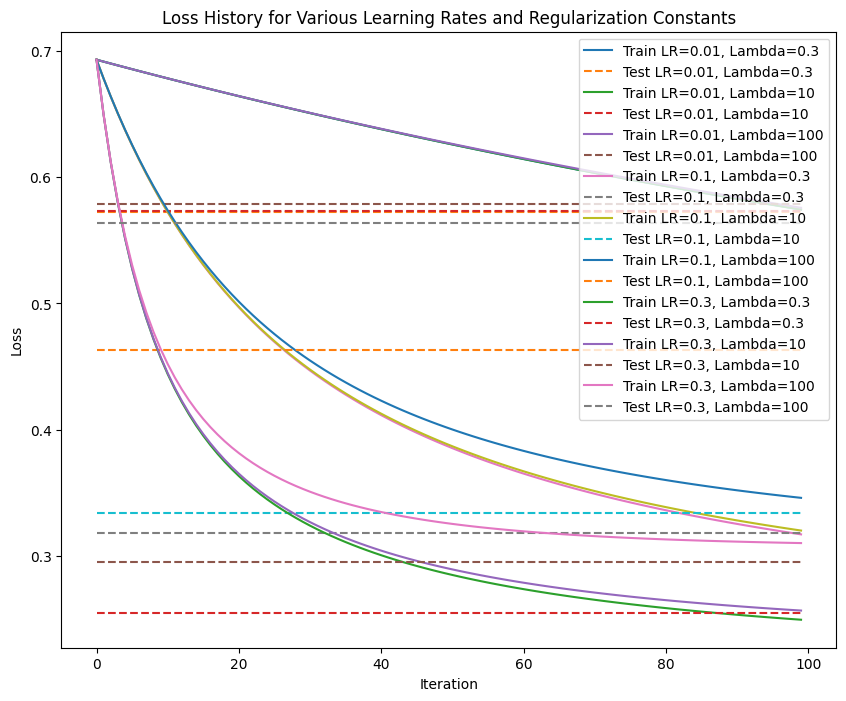

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_loss_histories(train_losses, test_losses, learning_rates, reg_lambdas):
    """
    Plots the loss histories for different learning rates and regularization constants.
    Arguments:
        train_losses: Dictionary with keys as (lr, reg_lambda) tuples and values as loss arrays for training data.
        test_losses: Dictionary with keys as (lr, reg_lambda) tuples and values as loss arrays for test data.
        learning_rates: List of learning rates used.
        reg_lambdas: List of regularization constants used.
    """
    plt.figure(figsize=(10, 8))
    for lr in learning_rates:
        for reg_lambda in reg_lambdas:
            key = (lr, reg_lambda)
            plt.plot(train_losses[key], label=f'Train LR={lr}, Lambda={reg_lambda}')
            plt.plot(test_losses[key], label=f'Test LR={lr}, Lambda={reg_lambda}', linestyle='--')

    plt.title('Loss History for Various Learning Rates and Regularization Constants')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Parameters
learning_rates = [0.01, 0.1, 0.3]
reg_lambdas = [0.3, 10, 100]
max_iters = 100

train_losses = {}
test_losses = {}
def accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

best_params = None
best_accuracy = -np.inf

# Assuming X_train, Y_train, X_test, and Y_test are defined
for lr in learning_rates:
    for reg_lambda in reg_lambdas:
        theta, loss_history = fit(X_train, Y_train, regLambda=reg_lambda, alpha=lr, maxNumIters=max_iters)
        train_losses[(lr, reg_lambda)] = loss_history

        Y_pred = predict(X_test, theta)
        test_loss = computeCost(theta, X_test, Y_test, reg_lambda)
        test_losses[(lr, reg_lambda)] = [test_loss] * max_iters  # Extend loss value for plotting

        # Calculate accuracy for the current parameters
        current_accuracy = accuracy(Y_test, Y_pred)
        if current_accuracy > best_accuracy:
            best_accuracy = current_accuracy
            best_params = (lr, reg_lambda)

print(f'Best Parameters: Learning Rate = {best_params[0]}, Lambda = {best_params[1]}')
print(f'Best Test Accuracy: {best_accuracy}')

plot_loss_histories(train_losses, test_losses, learning_rates, reg_lambdas)


## Naive Bayes

In this part, you will use the `GaussianNB` classifier to classify the data. You should not change the default parameters of this classifier. First, train the classifier on the training set and then find the accuracy of it on the test set.

**Question**: What is the accuracy of this method on test set?

**Answer**: Accuracy of GaussianNB on test data: 0.8810


In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

# Step 1: Initialize the GaussianNB classifier
gnb = GaussianNB()

# Step 2: Train the classifier on the training data
gnb.fit(X_train, Y_train)

# Step 3: Predict the labels on the test data
Y_pred = gnb.predict(X_test)

# Step 4: Calculate the accuracy of the classifier on the test data
accuracy = accuracy_score(Y_test, Y_pred)
print(f"Accuracy of GaussianNB on test data: {accuracy:.4f}")


Accuracy of GaussianNB on test data: 0.8810


## LDA (Linear Discriminant Analysis)

In this part, you will use the `LinearDiscriminantAnalysis` classifier to classify the data. You should not change the default parameters of this classifier. First, train the classifier on the training set and then find the accuracy of it on the test set.

**Question**: What is the accuracy of this method on test set?

**Answer**: Accuracy of LinearDiscriminantAnalysis on test data: 0.8990


In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score

# Step 1: Initialize the LinearDiscriminantAnalysis classifier
lda = LinearDiscriminantAnalysis()

# Step 2: Train the classifier on the training data
lda.fit(X_train, Y_train)

# Step 3: Predict the labels on the test data
Y_pred = lda.predict(X_test)

# Step 4: Calculate the accuracy of the classifier on the test data
accuracy = accuracy_score(Y_test, Y_pred)
print(f"Accuracy of LinearDiscriminantAnalysis on test data: {accuracy:.4f}")


Accuracy of LinearDiscriminantAnalysis on test data: 0.8990


## Conclution

**Question**: What is the best method for classifying this dataset? What is the best accuracy on the test set?

**Answer**: Based on the results, the best method for classifying this dataset is the logistic regression model. This model achieved the highest accuracy on the test set with a value of 0.902.

The accuracies for the other models are:
- GaussianNB: 0.8810
- LinearDiscriminantAnalysis: 0.8990

Thus, logistic regression not only outperformed the other models but also provided the best accuracy of 0.902 on the test set.